# Trading Crop Commodities Based on Extreme Weather Events During Critical Times of the Year

This presentation guides you through our thought process in attempting to capitalize on extreme weather events that damage the supply of certain crop futures.

## Coffee
Lets start off with coffee. The KC=F is the futures for coffee. 50% of the coffee beans in this futures contract is grown in the mountainous regions of Brazil, specifically, the Varginha region. We will use the code I wrote in coffee_data.py to extract daily temperature highs and lows from this region using NASA's API from the last 10 years. This exports a file called varignha_coffee_temps_10y.csv. Next, after doing some research, we found out that critical growth and harvest seasons for coffee occur at September, October, June, July, and August. We will watch for extreme hot and cold temperatures during these critical periods using the code below. Extreme temperatures is defined by temperatures that damage the crop to irreversible levels, essentially making the crop useless for harvest. Lets also store the list of extreme weather dates as we will be using that information for analysis later on.

[*********************100%***********************]  1 of 1 completed


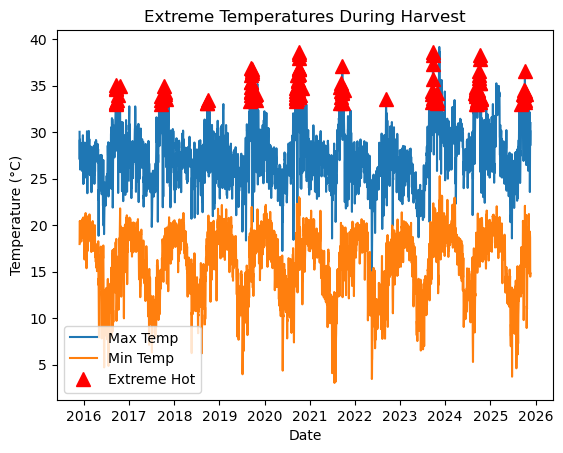

In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

coffee_df = pd.read_csv(
    "crops_data/varginha_coffee_temps_10y.csv", index_col="Date", parse_dates=True
)

coffee_prices = yf.download(
    "KC=F", start="2015-01-01", end="2025-11-24", auto_adjust=True
)
if isinstance(coffee_prices.columns, pd.MultiIndex):
    coffee_prices.columns = coffee_prices.columns.droplevel(1)

def plot_extremes(df, max_hot, min_cold, hot_months, cold_months):
    extreme_hots = []
    extreme_colds = []
    hot_labeled = False
    cold_labeled = False
    plt.plot(df.index, df["Max_Temp_C"], label="Max Temp")
    plt.plot(df.index, df["Min_Temp_C"], label="Min Temp")
    for i in range(len(df)):
        if df["Max_Temp_C"].iloc[i] > max_hot and df.index[i].month in hot_months:
            if not hot_labeled:
                plt.plot(
                    df.index[i],
                    df["Max_Temp_C"].iloc[i],
                    "r^",
                    markersize=10,
                    label="Extreme Hot",
                )
                hot_labeled = True
            else:
                plt.plot(df.index[i], df["Max_Temp_C"].iloc[i], "r^", markersize=10)
            extreme_hots.append(df.index[i].date())
        if df["Min_Temp_C"].iloc[i] < min_cold and df.index[i].month in cold_months:
            if not cold_labeled:
                plt.plot(
                    df.index[i],
                    df["Min_Temp_C"].iloc[i],
                    "b^",
                    markersize=10,
                    label="Extreme Cold",
                )
                cold_labeled = True
            else:
                plt.plot(df.index[i], df["Min_Temp_C"].iloc[i], "b^", markersize=10)
            extreme_colds.append(df.index[i].date())
    plt.title("Extreme Temperatures During Harvest")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()
    return pd.to_datetime(extreme_hots), pd.to_datetime(extreme_colds)

coffee_extreme_hot, coffee_extreme_cold = plot_extremes(coffee_df, 33, 2, [9, 10], [6, 7, 8])

We can see that all the extreme temperatures are hot, none of them are cold. It seems to be happening pretty frequently too, at regular intervals, which is not suprising due to global warming. Lets plot the dates on the price of the futures contract.

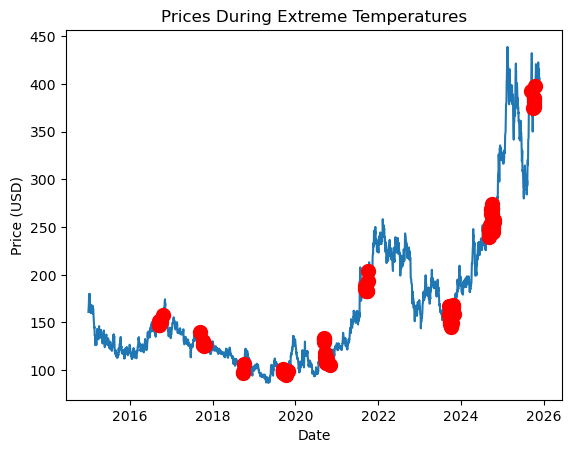

In [5]:
def plot_prices(prices, extreme_hots, extreme_colds):
    plt.plot(prices.index, prices["Close"])
    for date in extreme_hots:
        try:
            plt.plot(date, prices.loc[date]["Close"], "ro", markersize=10)
        except KeyError:
            continue
    for date in extreme_colds:
        try:
            plt.plot(date, prices.loc[date]["Close"], "bo", markersize=10)
        except KeyError:
            continue
    plt.title("Prices During Extreme Temperatures")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

plot_prices(coffee_prices, coffee_extreme_hot, coffee_extreme_cold)

Looks like this strategy looks pretty promising, as extreme weather events seem to follow up with surges in price. Obviously, we won't be buying at every single red signal, so lets alter this data to generate buy signals for us. To simplify things, we will make one dot appear for every unique month, that way, we will have at most one buy signal per month, which is much more manageable.

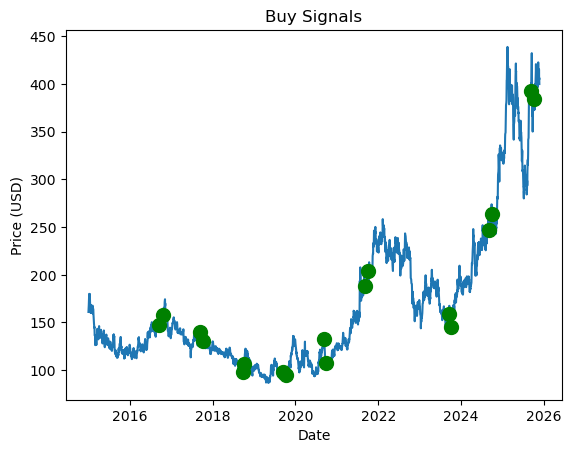

In [6]:
def buy_signals(extremes_hots, extremes_colds, prices):
    all_dates = extremes_hots.union(extremes_colds)
    all_dates = all_dates.sort_values()
    buy_signals = []
    seen_months = set()

    for date in all_dates:
        if date not in prices.index:
            continue
        month_key = (date.year, date.month)
        if month_key in seen_months:
            continue
        seen_months.add(month_key)
        buy_signals.append(date)

    plt.plot(prices.index, prices["Close"])
    for date in buy_signals:
        plt.plot(date, prices.loc[date]["Close"], "go", markersize=10)
    plt.title("Buy Signals")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()
    return buy_signals

coffee_buy_signals = buy_signals(coffee_extreme_hot, coffee_extreme_cold, coffee_prices)

That looks much better. Just by eyeballing, we can see this strategy is probably profitable for coffee. To be sure, lets plot the returns of a portfolio trading this specific strategy. Lets assume a holding period of 6 months for now. We will explore this parameter later on.

Final Portfolio Value: $19838.01
Annualized Return: 6.50%


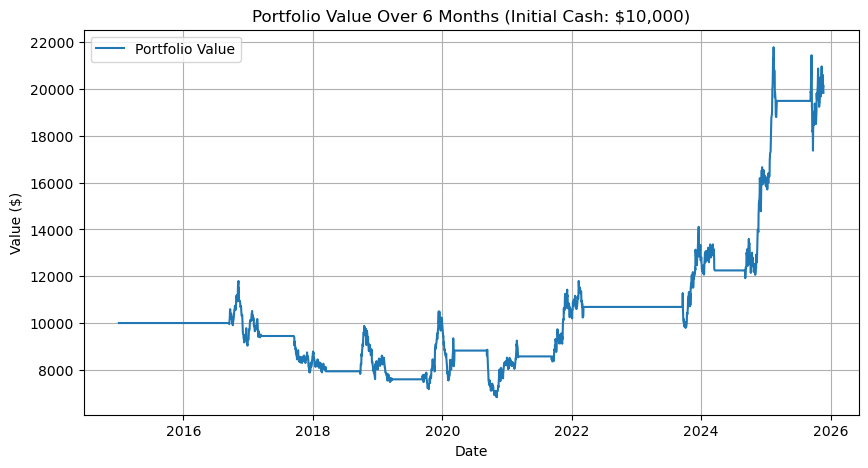

In [7]:
def backtest_strategy(prices, buy_signals, holding_period):
    cash = 10000
    portfolio_value = pd.Series(index=prices.index, data=cash, dtype=float)
    buy_signals = sorted(buy_signals)
    busy_until_date = None

    for buy_date in buy_signals:
        if buy_date not in prices.index:
            continue

        if busy_until_date is not None and buy_date < busy_until_date:
            continue

        buy_price = prices.loc[buy_date]["Close"]
        coffee_shares = cash / buy_price
        target_sell_date = buy_date + pd.DateOffset(months=holding_period)
        idx = prices.index.get_indexer([target_sell_date], method="nearest")[0]
        sell_date = prices.index[idx]

        if sell_date > prices.index[-1]:
            break

        period_prices = prices.loc[buy_date:sell_date]["Close"]
        portfolio_value.loc[buy_date:sell_date] = coffee_shares * period_prices
        sell_price = prices.loc[sell_date]["Close"]
        cash = coffee_shares * sell_price
        portfolio_value.loc[sell_date:] = cash
        busy_until_date = sell_date

    total_return = (cash - 10000) / 10000
    years = (prices.index[-1] - prices.index[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1 / years) - 1
    print(f"Final Portfolio Value: ${cash:.2f}")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")

    return cash, annualized_return, portfolio_value

def plot_returns(prices, buy_signals, holding_period):
    cash, annualized_return, portfolio_value = backtest_strategy(
        prices, buy_signals, holding_period
    )
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value.index, portfolio_value, label="Portfolio Value")
    plt.title(f"Portfolio Value Over {holding_period} Months (Initial Cash: $10,000)")
    plt.xlabel("Date")
    plt.ylabel("Value ($)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_returns(coffee_prices, coffee_buy_signals, 6)

Looks like we were right. This strategy looks promising, but we have to make sure we are not just getting lucky and trading random noise. We can determine this by finding the optimal holding period in months. Every commodity is different, as their supply chain and biological plants work differently. If the optimal holding period exhibits a hill-like shape, we can safely say we found a working strategy that isn't just lucky. We know the optimal holding period will obviously be between 1 and 12 months, so lets test that.

Final Portfolio Value: $10683.25
Annualized Return: 0.61%
Final Portfolio Value: $11265.56
Annualized Return: 1.10%
Final Portfolio Value: $20581.68
Annualized Return: 6.86%
Final Portfolio Value: $19812.28
Annualized Return: 6.48%
Final Portfolio Value: $19828.29
Annualized Return: 6.49%
Final Portfolio Value: $19838.01
Annualized Return: 6.50%
Final Portfolio Value: $24227.54
Annualized Return: 8.47%
Final Portfolio Value: $20256.14
Annualized Return: 6.70%
Final Portfolio Value: $20933.86
Annualized Return: 7.02%
Final Portfolio Value: $17253.24
Annualized Return: 5.14%
Final Portfolio Value: $20500.43
Annualized Return: 6.82%
Final Portfolio Value: $22016.02
Annualized Return: 7.52%


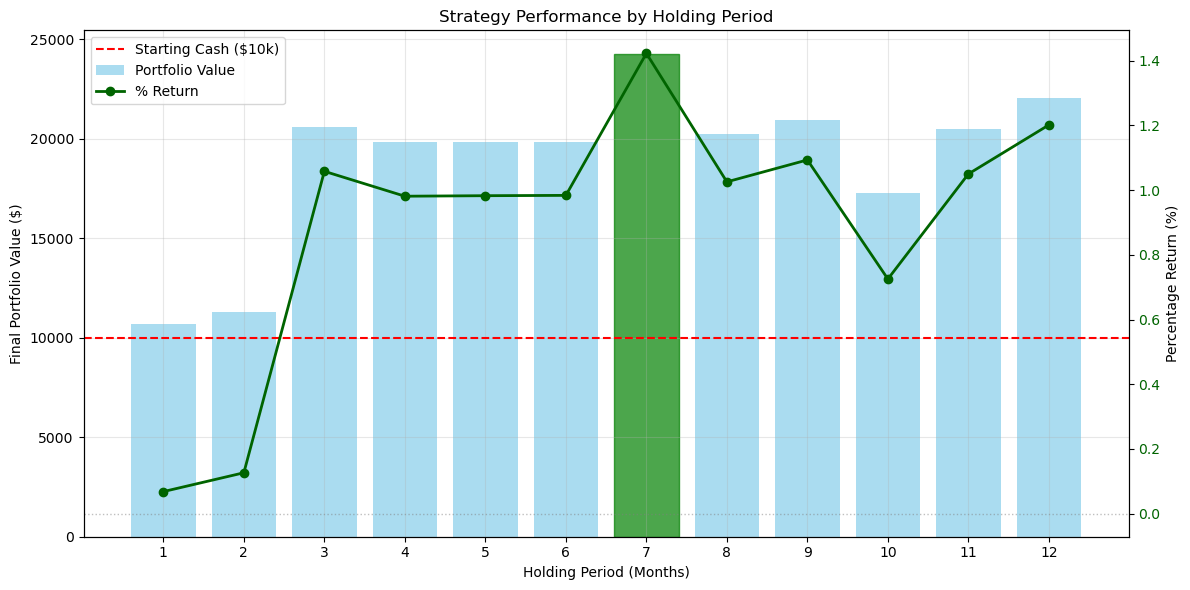

In [8]:
def optimize_holding_period(prices, buy_signals, min_months=1, max_months=12):
    cash_results = {}
    return_results = {}
    best_cash = 0
    best_month = 0

    for m in range(min_months, max_months + 1):
        cash, annualized_return, portfolio_value = backtest_strategy(
            prices, buy_signals, m
        )
        profit = cash - 10000
        cash_results[m] = cash
        return_results[m] = profit / 10000
        if cash > best_cash:
            best_cash = cash
            best_month = m

    return best_month, best_cash, cash_results, return_results


def plot_optimization_results(cash_results, return_results, best_months):
    cash_periods = list(cash_results.keys())
    cash_values = list(cash_results.values())
    return_values = list(return_results.values())

    fig, ax1 = plt.subplots(figsize=(12, 6))

    bars = ax1.bar(
        cash_periods, cash_values, color="skyblue", alpha=0.7, label="Portfolio Value"
    )
    bars[best_months - 1].set_color("green")
    ax1.axhline(
        y=10000,
        color="red",
        linestyle="--",
        linewidth=1.5,
        label="Starting Cash ($10k)",
    )
    ax1.set_xlabel("Holding Period (Months)")
    ax1.set_ylabel("Final Portfolio Value ($)")
    ax1.tick_params(axis="y")
    ax1.set_xticks(cash_periods)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    line = ax2.plot(
        cash_periods,
        return_values,
        color="darkgreen",
        marker="o",
        linewidth=2,
        markersize=6,
        label="% Return",
    )
    ax2.set_ylabel("Percentage Return (%)")
    ax2.tick_params(axis="y", labelcolor="darkgreen")
    ax2.axhline(y=0, color="gray", linestyle=":", linewidth=1, alpha=0.5)

    plt.title("Strategy Performance by Holding Period")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    plt.show()

best_coffee_months, best_coffee_pnl, coffee_cash_results, coffee_return_results = optimize_holding_period(
    coffee_prices, coffee_buy_signals, 1, 12
)
plot_optimization_results(coffee_cash_results, coffee_return_results, best_coffee_months)

This is not a promising sign. The graph looks random, with no hill-like or plateau shape. This tells us that coffee, even though generating good returns, might not be the most viable crop to trade consistently in the future. Lets try a different crop.

## Corn
Lets explore corn next. We do the same things with coffee by first extracting weather data. The file is called iowa_corn_temps_10y.csv

- Futures Ticker: ZC=F
- Region: Iowa
- Critical Months: May, July, August, September
- Max High Temperature: 34 Celcius
- Lowest Low temperature: 0 Celcius

[*********************100%***********************]  1 of 1 completed


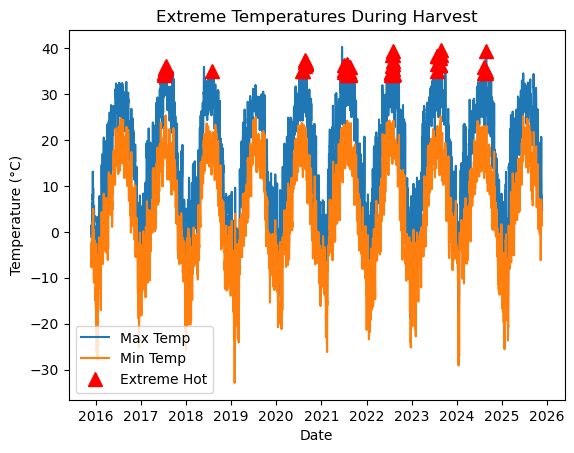

In [9]:
corn_df = pd.read_csv(
    "crops_data/iowa_corn_temps_10y.csv", index_col="Date", parse_dates=True
)

corn_prices = yf.download(
    "ZC=F", start="2015-01-01", end="2025-11-24", auto_adjust=True
)
if isinstance(corn_prices.columns, pd.MultiIndex):
    corn_prices.columns = corn_prices.columns.droplevel(1)

corn_extreme_hot, corn_extreme_cold = plot_extremes(corn_df, 34, 0, [7, 8], [5, 9])

Now, lets plot these dates on the prices of these contracts and generate buy signals the same way.

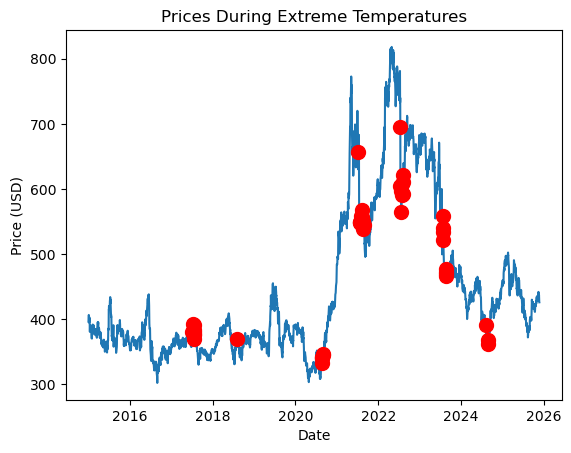

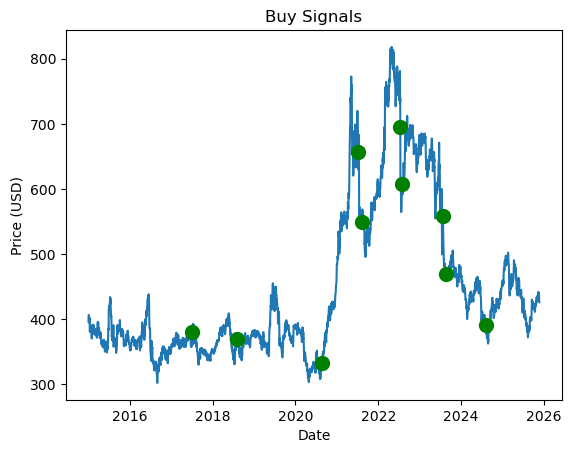

In [10]:
plot_prices(corn_prices, corn_extreme_hot, corn_extreme_cold)
corn_buy_signals = buy_signals(corn_extreme_hot, corn_extreme_cold, corn_prices)

Now, lets plot the returns for our backtest.

Final Portfolio Value: $14603.38
Annualized Return: 3.54%


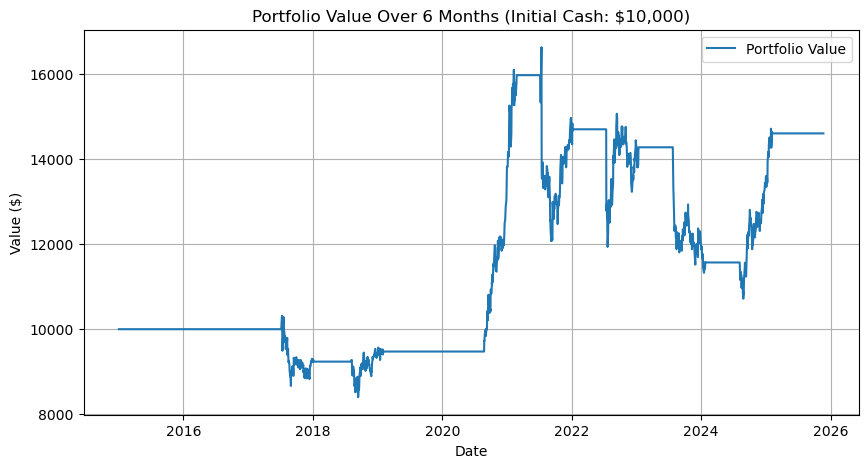

In [11]:
plot_returns(corn_prices, corn_buy_signals, 6)

Lets optimize the holding period to see if we were just trading random noise or not.

Final Portfolio Value: $6052.83
Annualized Return: -4.51%
Final Portfolio Value: $8229.82
Annualized Return: -1.77%
Final Portfolio Value: $8806.68
Annualized Return: -1.16%
Final Portfolio Value: $9032.16
Annualized Return: -0.93%
Final Portfolio Value: $11659.50
Annualized Return: 1.42%
Final Portfolio Value: $14603.38
Annualized Return: 3.54%
Final Portfolio Value: $12304.95
Annualized Return: 1.92%
Final Portfolio Value: $18463.65
Annualized Return: 5.79%
Final Portfolio Value: $19857.00
Annualized Return: 6.50%
Final Portfolio Value: $22556.83
Annualized Return: 7.76%
Final Portfolio Value: $19514.45
Annualized Return: 6.33%
Final Portfolio Value: $10065.20
Annualized Return: 0.06%


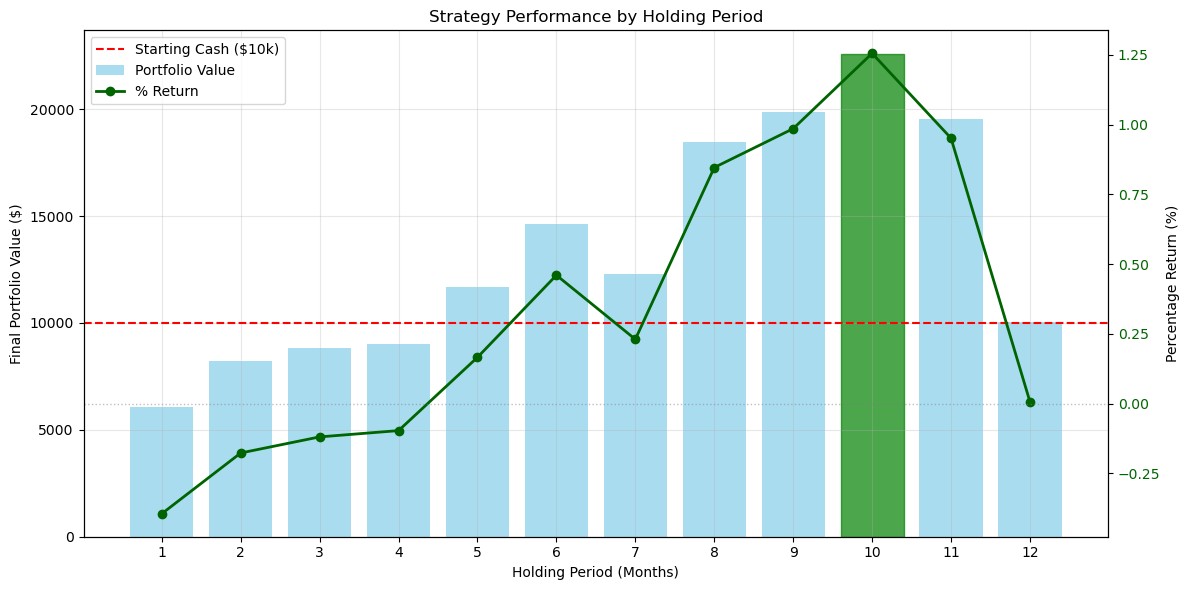

In [12]:
best_corn_months, best_corn_pnl, corn_cash_results, corn_return_results = optimize_holding_period(
    corn_prices, corn_buy_signals, 1, 12
)
plot_optimization_results(corn_cash_results, corn_return_results, best_corn_months)

This looks much better! We can clearly see a clear hill shape that says we weren't just trading random noise. The peaks of the hill is also above the breakeven point. So not only is corn is a viable strategy, it is also profitable, with an optimal holding period of 10 months. Lets see how our returns look like by holding 10 months.

Final Portfolio Value: $22556.83
Annualized Return: 7.76%


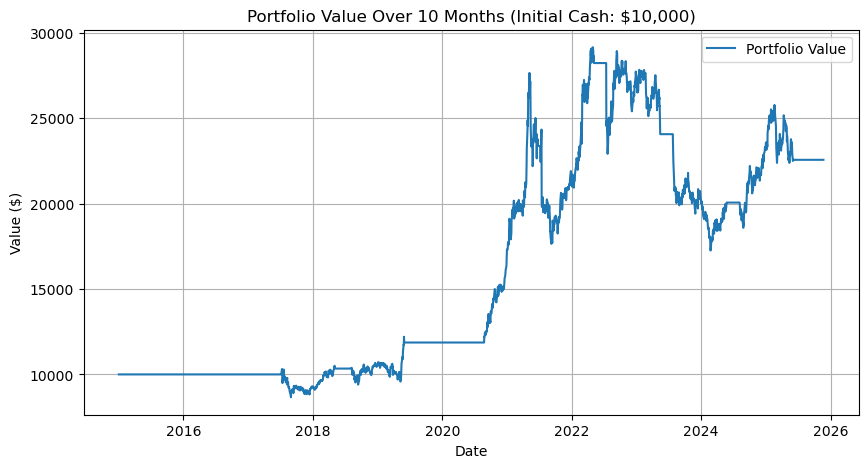

In [13]:
plot_returns(corn_prices, corn_buy_signals, 10)

## Wheat
Lets try wheat this time.

- Futures Ticker: KE=F
- Region: Kansas
- Critical Months: April, May, June
- Max High Temperature: 37 Celcius
- Lowest Low temperature: -3 Celcius

[*********************100%***********************]  1 of 1 completed


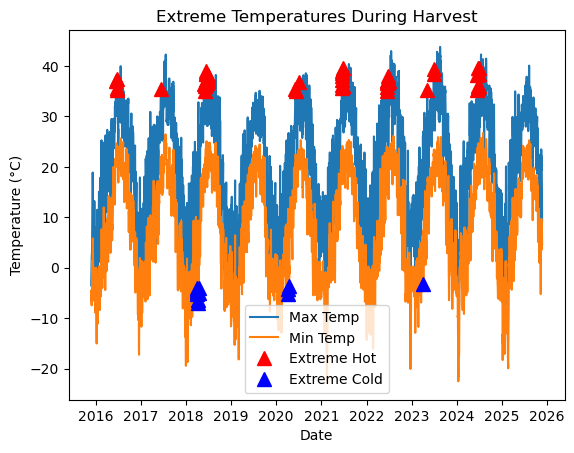

In [14]:
wheat_df = pd.read_csv("crops_data/kansas_wheat_temps_10y.csv", index_col="Date", parse_dates=True)

wheat_prices = yf.download(
    "KE=F", start="2015-01-01", end="2025-11-24", auto_adjust=True
)
if isinstance(wheat_prices.columns, pd.MultiIndex):
    wheat_prices.columns = wheat_prices.columns.droplevel(1)

wheat_extreme_hot, wheat_extreme_cold = plot_extremes(wheat_df, 35, -3, [5, 6], [4, 5])

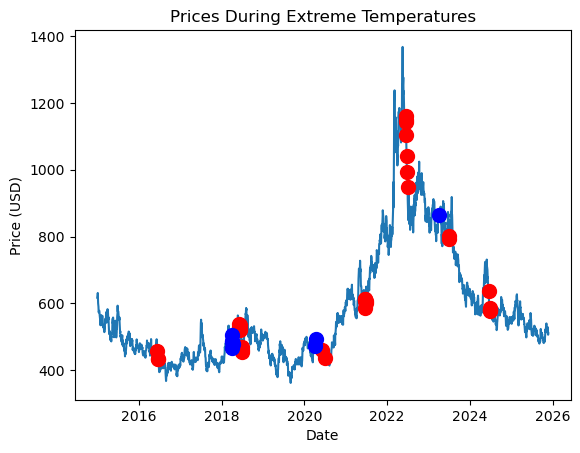

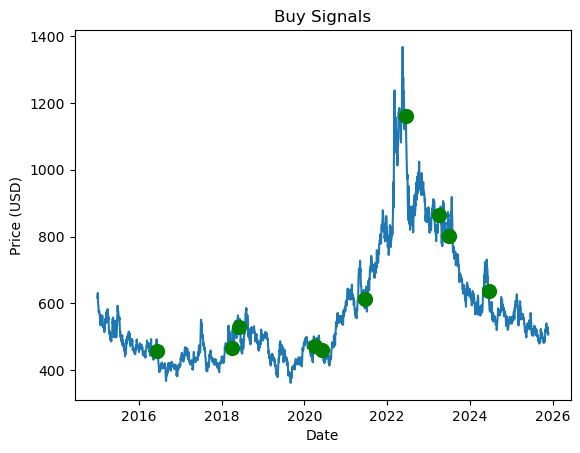

In [15]:
plot_prices(wheat_prices, wheat_extreme_hot, wheat_extreme_cold)
wheat_buy_signals = buy_signals(wheat_extreme_hot, wheat_extreme_cold, wheat_prices)

Final Portfolio Value: $7004.52
Annualized Return: -3.22%


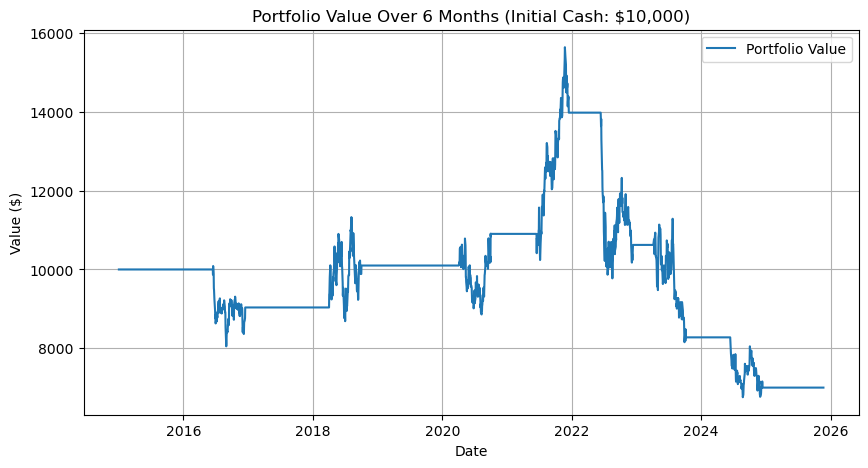

In [16]:
plot_returns(wheat_prices, wheat_buy_signals, 6)

Seems like we incurred a loss using this strategy on wheat. This is not suprising, as wheat is considered a "zombie crop." During extreme weather events, they can appear dead and slow down their metabolic processes, and resume growing after temperatures return to normal. So technically, these extreme temperatures did stall their growth, it doesn't kill the crop. And without killing the crop and creating a shortage in supply, this method obviously won't work.

So quick mental note: Resillient crops wont be profitable with this method. We need to chose crops sensitive to changes in temperature.

## Soybeans
Soybeans are known to be sensitive to changes in temperature, so lets try that.

- Futures Ticker: ZS=F
- Region: Iowa
- Critical Months: August, September, October
- Max High Temperature: 33 Celcius
- Lowest Low temperature: -2 Celcius

[*********************100%***********************]  1 of 1 completed


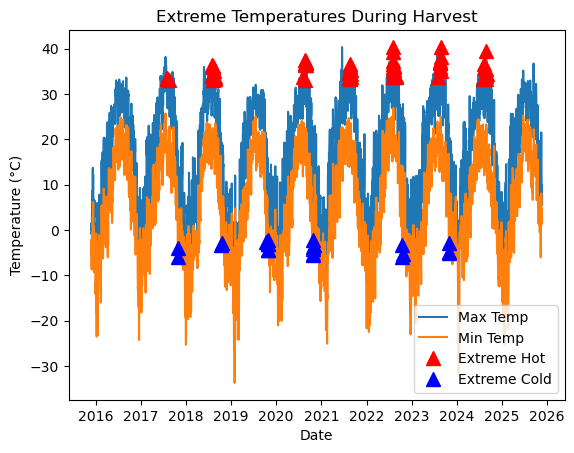

In [17]:
soybeans_df = pd.read_csv(
    "crops_data/iowa_soybean_temps_10y.csv", index_col="Date", parse_dates=True
)

soybeans_prices = yf.download(
    "ZS=F", start="2015-01-01", end="2025-11-24", auto_adjust=True
)
if isinstance(soybeans_prices.columns, pd.MultiIndex):
    soybeans_prices.columns = soybeans_prices.columns.droplevel(1)

soybeans_extreme_hot, soybeans_extreme_cold = plot_extremes(soybeans_df, 33, -2, [8], [9, 10])

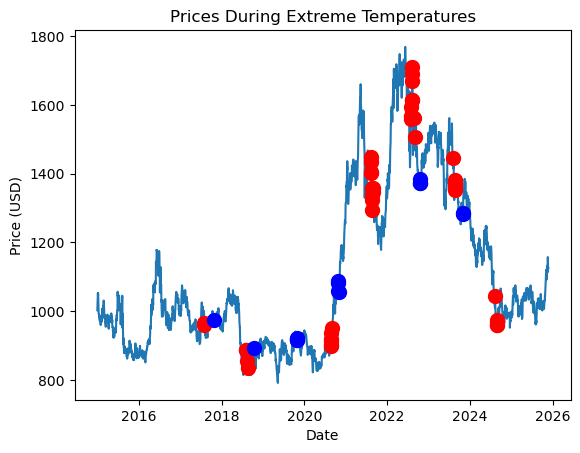

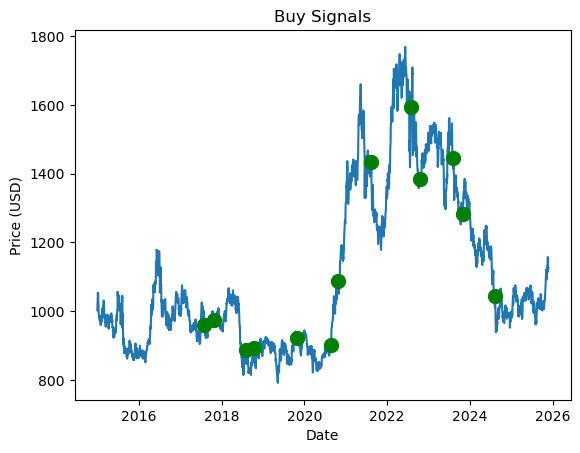

In [18]:
plot_prices(soybeans_prices, soybeans_extreme_hot, soybeans_extreme_cold)
soybeans_buy_signals = buy_signals(soybeans_extreme_hot, soybeans_extreme_cold, soybeans_prices)

Final Portfolio Value: $13092.32
Annualized Return: 2.51%


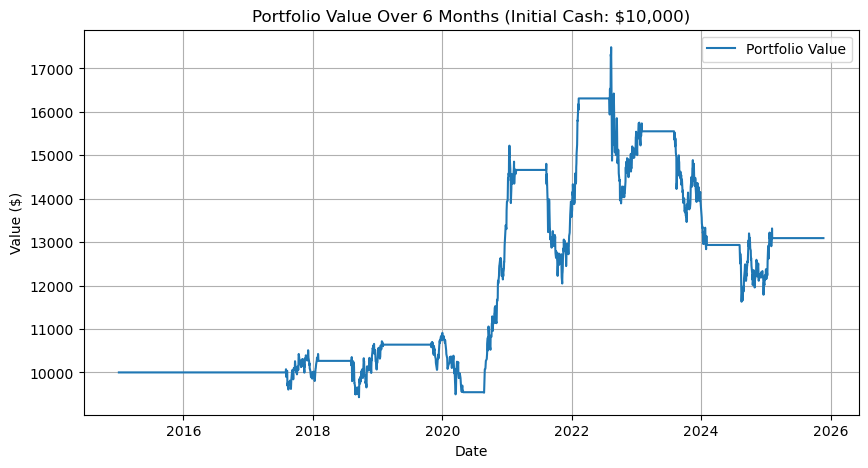

In [19]:
plot_returns(soybeans_prices, soybeans_buy_signals, 6)

Final Portfolio Value: $8658.51
Annualized Return: -1.31%
Final Portfolio Value: $9341.90
Annualized Return: -0.62%
Final Portfolio Value: $8235.04
Annualized Return: -1.77%
Final Portfolio Value: $9668.65
Annualized Return: -0.31%
Final Portfolio Value: $11023.54
Annualized Return: 0.90%
Final Portfolio Value: $13092.32
Annualized Return: 2.51%
Final Portfolio Value: $13623.67
Annualized Return: 2.88%
Final Portfolio Value: $14604.10
Annualized Return: 3.54%
Final Portfolio Value: $13748.24
Annualized Return: 2.97%
Final Portfolio Value: $9584.33
Annualized Return: -0.39%
Final Portfolio Value: $8750.05
Annualized Return: -1.22%
Final Portfolio Value: $8568.18
Annualized Return: -1.41%


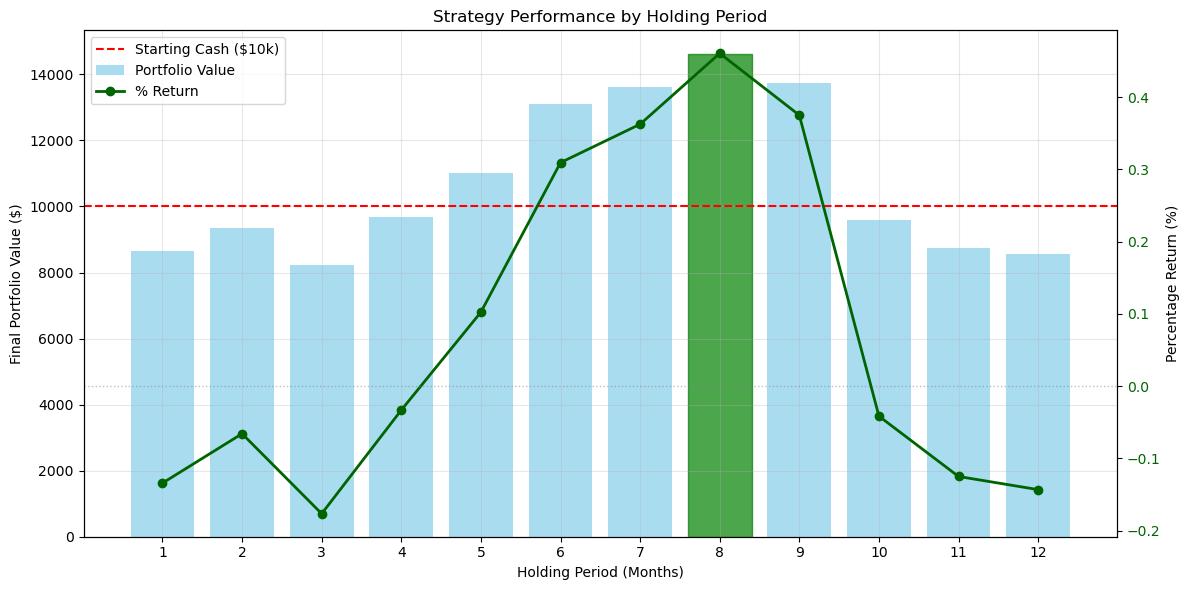

In [20]:
best_soybeans_months, best_soybeans_pnl, soybeans_cash_results, soybeans_return_results = optimize_holding_period(
    soybeans_prices, soybeans_buy_signals, 1, 12
)
plot_optimization_results(soybeans_cash_results, soybeans_return_results, best_soybeans_months)

Nice! Looks like this strategy is not random and profitable for soybeans! The profitability is not as high as corn. We can see this by the distance of the green lines above the red line not being as high as corn. Let's see the returns using the optimal holding period of 8 months.

Final Portfolio Value: $14604.10
Annualized Return: 3.54%


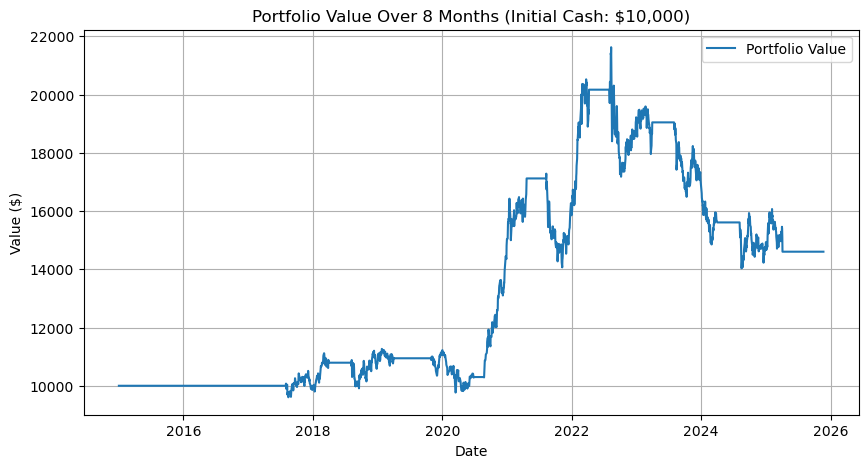

In [21]:
plot_returns(soybeans_prices, soybeans_buy_signals, 8)

# What About Animals? (lean hogs)
In past tests, we only used crops. Lets try experimenting with live animals. Lets start with Lean Hogs, which are pigs.

- Lean Hogs Ticker: HE=F
- Location: Iowa (Hog Belt)
- Critical Max Temperature: 38 Celcius
- Critical Min Temperature: -20 Celcius
- Critical Time Periods: all year round

But wait...lets dig deeper into how the lean hogs industry works.
Heat: Trucks run fine. You can load pigs. In fact, driving them in a truck with airflow is sometimes better than a hot barn. Result: Supply surges, prices drop. Farmers rush to sell pigs who died from overheating.

Cold: Diesel gels in truck engines. Roads ice over. Ramps become slippery/dangerous. Farmers physically cannot get the animals to the slaughterhouse. Dead pigs are left dead and have no where to go, shocking the supply, prices surge.

So, technically, we should only be buying extreme cold events. Lets implement that.


[*********************100%***********************]  1 of 1 completed


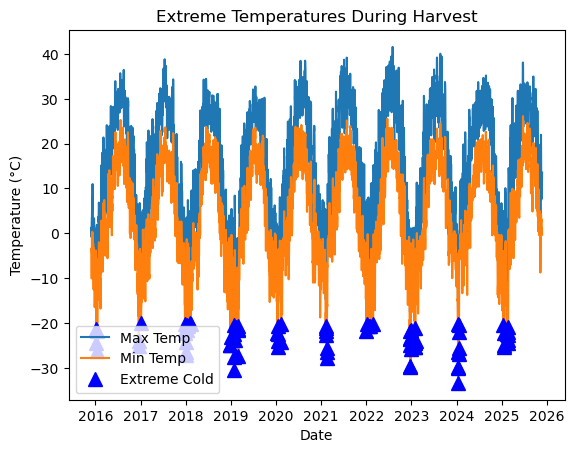

In [22]:
hogs_df = pd.read_csv(
    "crops_data/iowa_hog_weather_10y.csv", index_col="Date", parse_dates=True
)

hogs_prices = yf.download(
    "HE=F", start="2015-01-01", end="2025-11-24", auto_adjust=True
)
if isinstance(hogs_prices.columns, pd.MultiIndex):
    hogs_prices.columns = hogs_prices.columns.droplevel(1)

hogs_extreme_hot, hogs_extreme_cold = plot_extremes(hogs_df, 38, -20, [13], [12, 1, 2, 3])

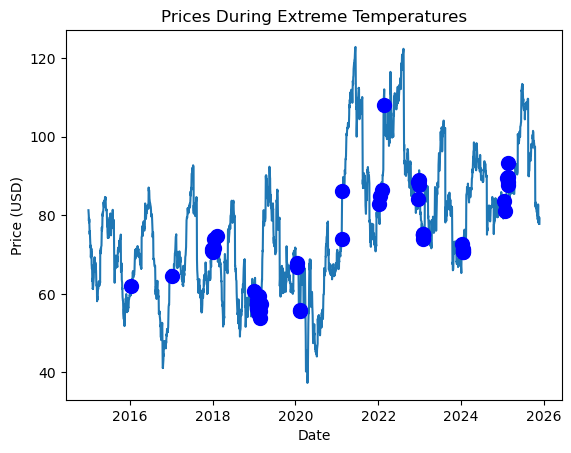

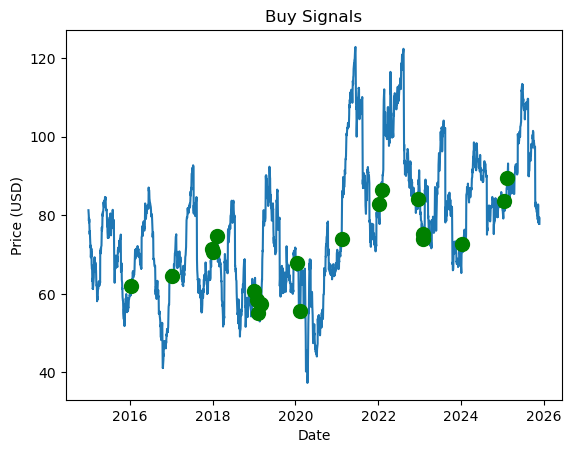

In [23]:
plot_prices(hogs_prices, hogs_extreme_hot, hogs_extreme_cold)
hogs_buy_signals = buy_signals(hogs_extreme_hot, hogs_extreme_cold, hogs_prices)

Final Portfolio Value: $60653.38
Annualized Return: 18.01%


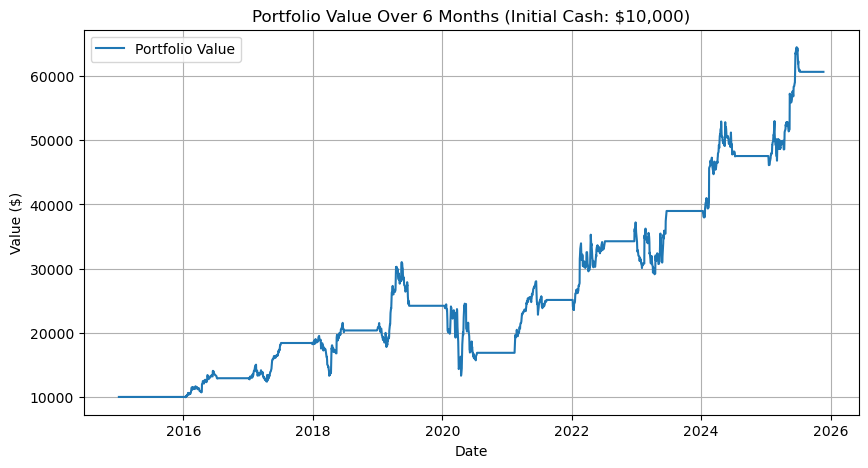

In [24]:
plot_returns(hogs_prices, hogs_buy_signals, 6)

Final Portfolio Value: $13726.59
Annualized Return: 2.95%
Final Portfolio Value: $27179.74
Annualized Return: 9.62%
Final Portfolio Value: $16069.11
Annualized Return: 4.45%
Final Portfolio Value: $38130.98
Annualized Return: 13.08%
Final Portfolio Value: $56603.98
Annualized Return: 17.26%
Final Portfolio Value: $60653.38
Annualized Return: 18.01%
Final Portfolio Value: $43221.38
Annualized Return: 14.39%
Final Portfolio Value: $11916.51
Annualized Return: 1.62%
Final Portfolio Value: $11946.54
Annualized Return: 1.65%
Final Portfolio Value: $5454.41
Annualized Return: -5.42%
Final Portfolio Value: $7599.31
Annualized Return: -2.49%
Final Portfolio Value: $11293.43
Annualized Return: 1.12%


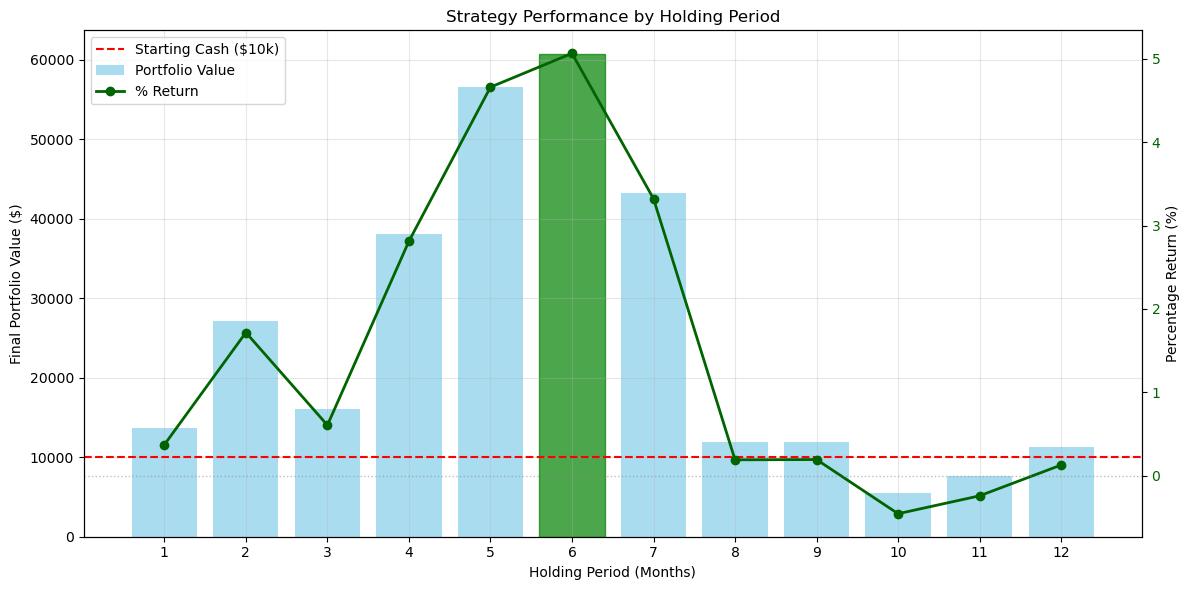

In [25]:
best_hogs_months, best_hogs_pnl, hogs_cash_results, hogs_return_results = optimize_holding_period(
    hogs_prices, hogs_buy_signals, 1, 12
)
plot_optimization_results(hogs_cash_results, hogs_return_results, best_hogs_months)

Wow! Our best model so far. We can be assured we aren't getting lucky or trading random noise due to our previous graph, and we are also making great returns of 18% a year. The equity curve also looks the most consistent, with less volatile fluctuations, which is also what we want.

# But Wait...We're trading futures contracts, not spot prices.
In our backtesting, we were always trading future contracts, not spot prices. We didn't account for the cost of rolling over our contracts to a later expiration date, a crucial cost of carrying futures contracts. Lets see how this changes our results. There are 2 types of things that can happen to a rolling contract:

## Contango
Contango is when the futures contract is higher than the spot price at expiration. This is can happen when the futures contract is more expensive to hold, and the cost of holding the futures contract is higher than the cost of holding the spot price.

**Reasons this might occur (and it usually does for crops like corn and soybeans):**
- Storage Costs: Physical goods take up space.
- Insurance: Physical goods can be damaged or lost.
- Interest: The money tied up in buying the goods could have been earning interest elsewhere.

**What this means for us:**
rolling contracts will incur a cost.

## Backwardation
Backwardation is when the futures contract is lower than the spot price at expiration. This is can happen when the futures contract is less expensive to hold, and the cost of holding the futures contract is lower than the cost of holding the spot price.

**Reasons this might occur (usually rarer):**
- There is a Shortage: A pipeline broke, a war started, or a harvest failed. People need the physical good immediately to keep factories running or cars moving, so they bid up the current price.
- Convenience Yield: This is a fancy finance term that essentially means "the benefit of actually holding the physical item." If you are a bakery and there is a wheat shortage, having wheat in your warehouse today is valuable because it keeps you in business. You are willing to pay extra for that security.
- Right before harvest: Bakeries and factories are desperate for the last few remaining bushels to keep running until the new crop arrives. Silos are almost empty. 

**What this means for us:**
rolling contracts will be profitable.

## Lets define some rolling yields for our crops and animals
Note: This is not the real yield from month to month, but it is a good enough proxy for our purposes. If you wish to calculate the real yield, you can use the following formula: 

**Rolling Yield = (Total Change in Futures Prices) - (Total Change in Spot Price)**

You would have to calculate the rolling yield for each month you need to roll your futures contract, which can be very tedious. The parameters below are based on the average rolling yield for each crop/animal.

In [33]:
def get_seasonal_drag(current_date, commodity):
    if commodity == 'coffee':
        return 0.015

    elif commodity == 'corn':
        return 0.02

    elif commodity == 'lean hogs':
        return 0.025

    elif commodity == 'soybeans':
        return 0.015

def get_roll_months(current_date, commodity):
    month = current_date.month

    if commodity == 'coffee':
        if month in [3, 5, 7, 9, 12]:
            return True
        return False

    elif commodity == 'corn':
        if month in [3, 5, 7, 9, 12]:
            return True
        return False

    elif commodity == 'lean hogs':
        if month in [2, 4, 6, 8, 10, 12]:
            return True
        return False

    elif commodity == 'soybeans':
        if month in [1, 3, 5, 7, 8, 9, 11]:
                return True
        return False

## Now, lets redefine our backtest function to account for the drag

In [34]:
def backtest_strategy(prices, buy_signals, holding_period, commodity):
    cash = 10000
    portfolio_value = pd.Series(index=prices.index, data=cash, dtype=float)
    buy_signals = sorted(buy_signals)
    busy_until_date = None

    for buy_date in buy_signals:
        if buy_date not in prices.index:
            continue

        if busy_until_date is not None and buy_date < busy_until_date:
            continue

        roll_months = []
        for i in range(1, holding_period + 1):
            if get_roll_months(buy_date + pd.DateOffset(months=i), commodity):
                roll_months.append(i)

        total_drag = 1
        for roll_month in roll_months:
            drag = get_seasonal_drag(buy_date + pd.DateOffset(months=roll_month), commodity)
            total_drag *= (1 - drag)

        buy_price = prices.loc[buy_date]["Close"]
        soybeans_shares = cash / buy_price
        target_sell_date = buy_date + pd.DateOffset(months=holding_period)
        idx = prices.index.get_indexer([target_sell_date], method="nearest")[0]
        sell_date = prices.index[idx]

        if sell_date > prices.index[-1]:
            break

        period_prices = prices.loc[buy_date:sell_date]["Close"]
        portfolio_value.loc[buy_date:sell_date] = soybeans_shares * period_prices
        sell_price = prices.loc[sell_date]["Close"]
        cash = soybeans_shares * sell_price * total_drag
        portfolio_value.loc[sell_date:] = cash
        busy_until_date = sell_date

    total_return = (cash - 10000) / 10000
    years = (prices.index[-1] - prices.index[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1 / years) - 1
    print(f"Final Portfolio Value: ${cash:.2f}")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")

    return cash, annualized_return, portfolio_value

# Add a parameter to optimize_holding_period()
def optimize_holding_period(prices, buy_signals, commodity, min_months=1, max_months=12):
    cash_results = {}
    return_results = {}
    best_cash = 0
    best_month = 0

    for m in range(min_months, max_months + 1):
        cash, annualized_return, portfolio_value = backtest_strategy(
            prices, buy_signals, m, commodity
        )
        profit = cash - 10000
        cash_results[m] = cash
        return_results[m] = profit / 10000
        if cash > best_cash:
            best_cash = cash
            best_month = m

    return best_month, best_cash, cash_results, return_results

#Add a parameter to plot_returns()
def plot_returns(prices, buy_signals, holding_period, commodity):
    cash, annualized_return, portfolio_value = backtest_strategy(
        prices, buy_signals, holding_period, commodity
    )
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value.index, portfolio_value, label="Portfolio Value")
    plt.title(f"Portfolio Value Over {holding_period} Months (Initial Cash: $10,000)")
    plt.xlabel("Date")
    plt.ylabel("Value ($)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Lets Observe the Change
We can expect the optimal holding period to decrease, as holding costs are usually positive. Knowing this, we can also expect the total return to be lower than before.

## Coffee
Perviously, we ruled out coffee to be a viable crop to trade, but lets see if it still exhibits a random walk after implementing roll costs.

Final Portfolio Value: $10683.25
Annualized Return: 0.61%
Final Portfolio Value: $11265.56
Annualized Return: 1.10%
Final Portfolio Value: $17964.16
Annualized Return: 5.53%
Final Portfolio Value: $17292.61
Annualized Return: 5.16%
Final Portfolio Value: $17306.58
Annualized Return: 5.17%
Final Portfolio Value: $15112.99
Annualized Return: 3.87%
Final Portfolio Value: $18457.02
Annualized Return: 5.79%
Final Portfolio Value: $13468.98
Annualized Return: 2.77%
Final Portfolio Value: $13919.62
Annualized Return: 3.08%
Final Portfolio Value: $10013.25
Annualized Return: 0.01%
Final Portfolio Value: $11897.82
Annualized Return: 1.61%
Final Portfolio Value: $12027.85
Annualized Return: 1.71%


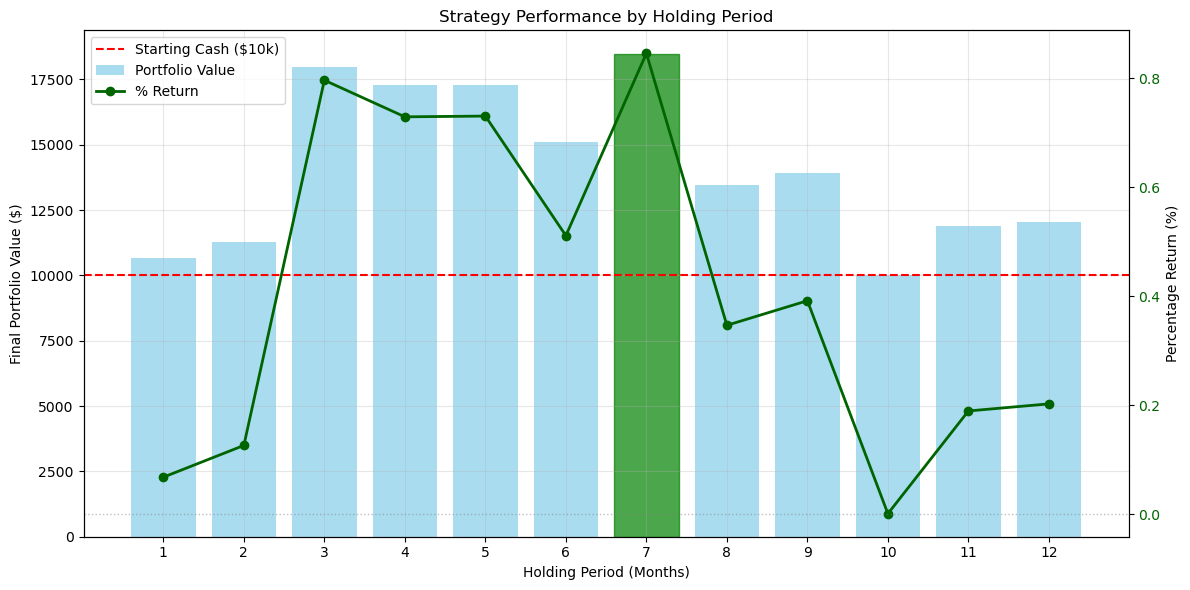

In [35]:
best_coffee_months, best_coffee_pnl, coffee_cash_results, coffee_return_results = optimize_holding_period(
    coffee_prices, coffee_buy_signals, 'coffee', 1, 12,
)
plot_optimization_results(coffee_cash_results, coffee_return_results, best_coffee_months)

Coffee still looks like its exhibiting a random walk, but we'll keep it for now for research purposes. Even though we have great returns, it is highly likely it is just because of luck.

Final Portfolio Value: $18457.02
Annualized Return: 5.79%


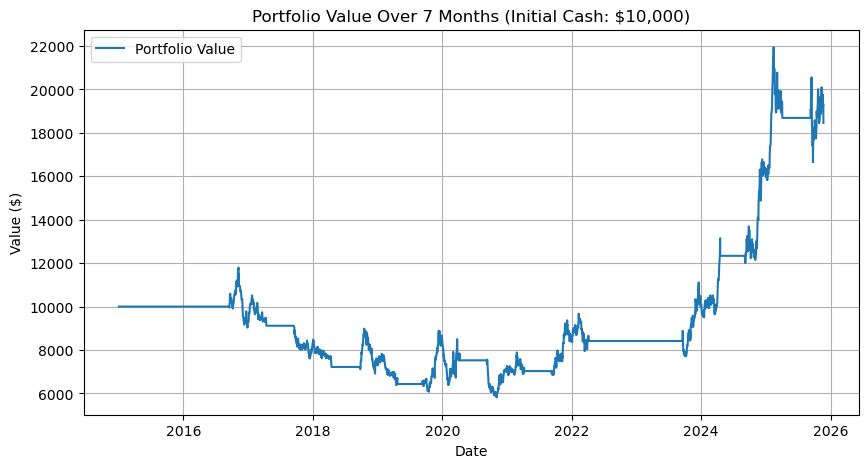

In [44]:
plot_returns(coffee_prices, coffee_buy_signals, 7, 'coffee')

## Corn

Final Portfolio Value: $5582.94
Annualized Return: -5.21%
Final Portfolio Value: $7144.51
Annualized Return: -3.04%
Final Portfolio Value: $7645.31
Annualized Return: -2.44%
Final Portfolio Value: $7379.93
Annualized Return: -2.75%
Final Portfolio Value: $8787.09
Annualized Return: -1.18%
Final Portfolio Value: $11005.72
Annualized Return: 0.88%
Final Portfolio Value: $8728.17
Annualized Return: -1.24%
Final Portfolio Value: $12079.95
Annualized Return: 1.75%
Final Portfolio Value: $12227.55
Annualized Return: 1.86%
Final Portfolio Value: $12811.74
Annualized Return: 2.30%
Final Portfolio Value: $10223.29
Annualized Return: 0.20%
Final Portfolio Value: $5490.41
Annualized Return: -5.36%


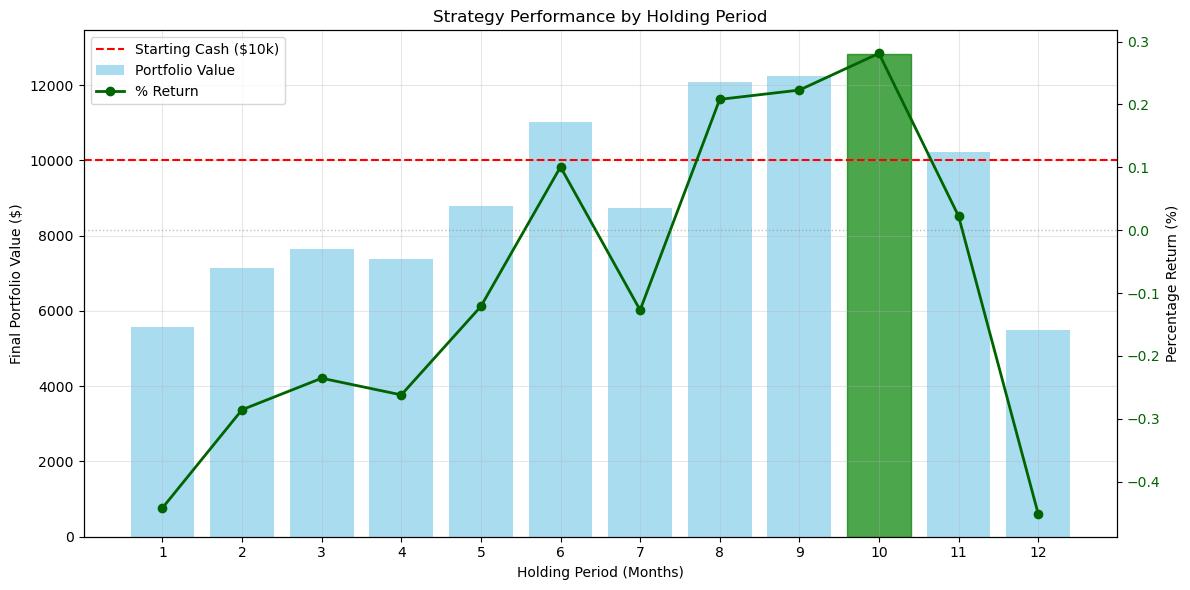

In [37]:
best_corn_months, best_corn_pnl, corn_cash_results, corn_return_results = optimize_holding_period(
    corn_prices, corn_buy_signals, 'corn', 1, 12,
)
plot_optimization_results(corn_cash_results, corn_return_results, best_corn_months)

Looks like the holding period didn't decline with corn. This can probably be explained by how roll yields aren't drastic enough to make an impact on gains for corn futures.

Final Portfolio Value: $12811.74
Annualized Return: 2.30%


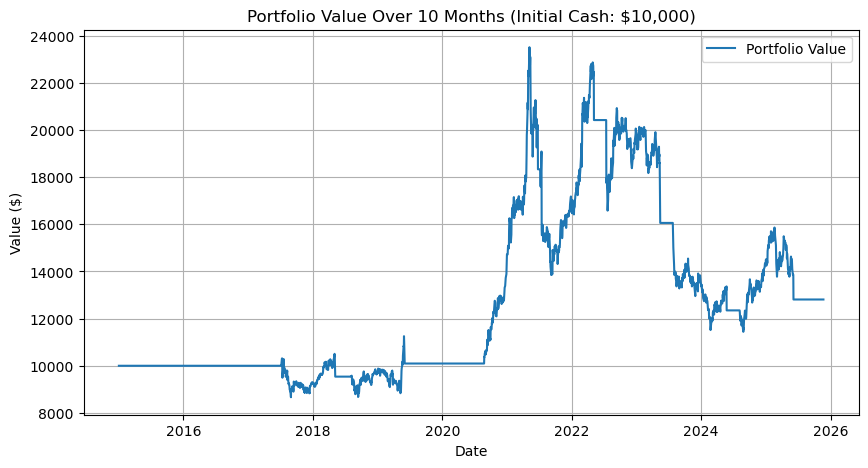

In [38]:
plot_returns(corn_prices, corn_buy_signals, 10, 'corn')

## Lean Hogs

Final Portfolio Value: $11497.28
Annualized Return: 1.29%
Final Portfolio Value: $20572.93
Annualized Return: 6.85%
Final Portfolio Value: $10716.81
Annualized Return: 0.64%
Final Portfolio Value: $22981.07
Annualized Return: 7.94%
Final Portfolio Value: $29306.70
Annualized Return: 10.38%
Final Portfolio Value: $28378.76
Annualized Return: 10.06%
Final Portfolio Value: $17372.60
Annualized Return: 5.20%
Final Portfolio Value: $4328.46
Annualized Return: -7.40%
Final Portfolio Value: $3727.81
Annualized Return: -8.67%
Final Portfolio Value: $1538.08
Annualized Return: -15.80%
Final Portfolio Value: $1840.91
Annualized Return: -14.40%
Final Portfolio Value: $3350.02
Annualized Return: -9.56%


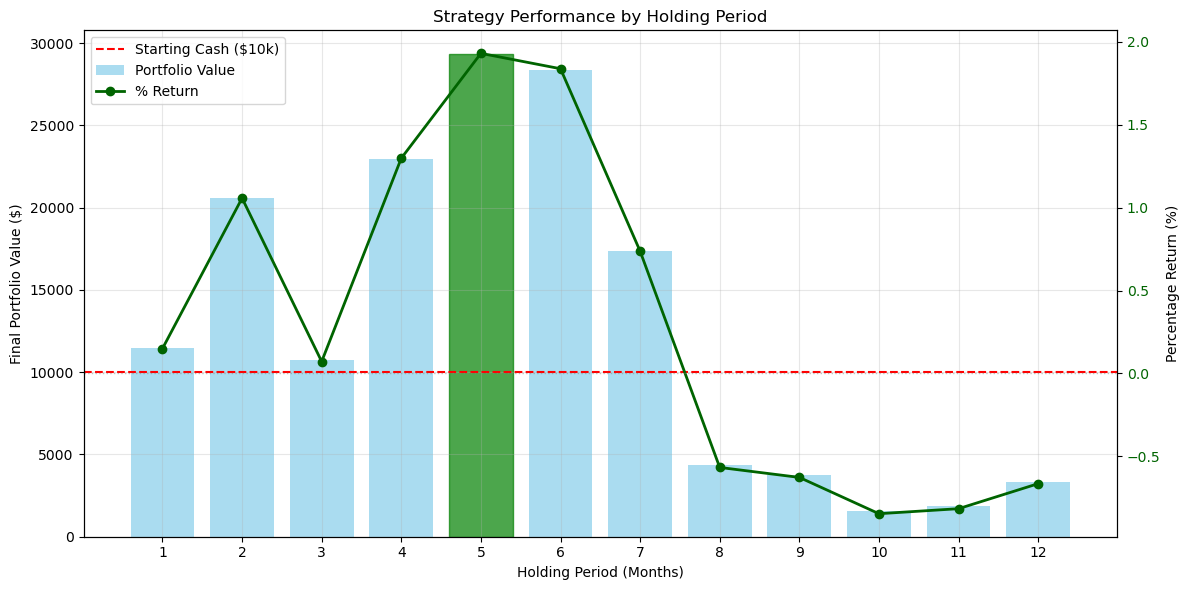

In [43]:
best_hogs_months, best_hogs_pnl, hogs_cash_results, hogs_return_results = optimize_holding_period(
    hogs_prices, hogs_buy_signals, 'lean hogs', 1, 12,
)
plot_optimization_results(hogs_cash_results, hogs_return_results, best_hogs_months)

Final Portfolio Value: $29306.70
Annualized Return: 10.38%


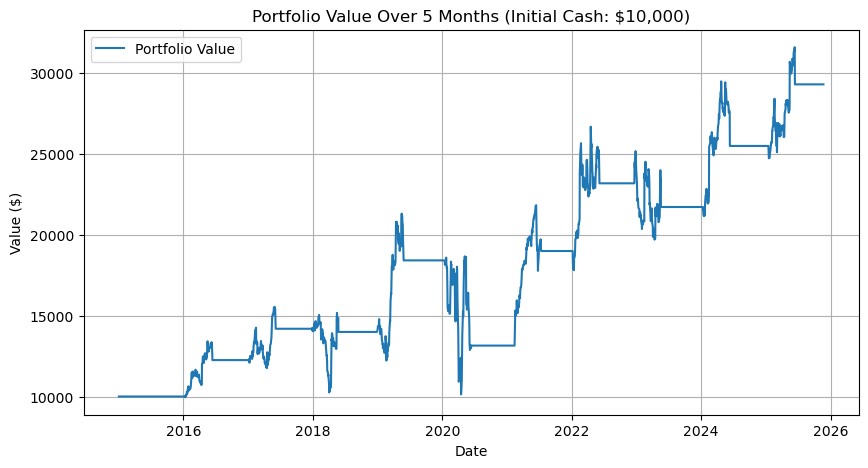

In [40]:
plot_returns(hogs_prices, hogs_buy_signals, 5, 'lean hogs')

Looks like lean hogs is still very profitable after making our backtest more sophisticated.

## Soybeans

Final Portfolio Value: $7114.01
Annualized Return: -3.08%
Final Portfolio Value: $7675.49
Annualized Return: -2.40%
Final Portfolio Value: $6466.14
Annualized Return: -3.93%
Final Portfolio Value: $7591.81
Annualized Return: -2.50%
Final Portfolio Value: $7669.92
Annualized Return: -2.41%
Final Portfolio Value: $9109.32
Annualized Return: -0.85%
Final Portfolio Value: $8399.50
Annualized Return: -1.59%
Final Portfolio Value: $9003.98
Annualized Return: -0.96%
Final Portfolio Value: $7510.97
Annualized Return: -2.60%
Final Portfolio Value: $5479.01
Annualized Return: -5.38%
Final Portfolio Value: $4499.92
Annualized Return: -7.07%
Final Portfolio Value: $4541.61
Annualized Return: -6.99%


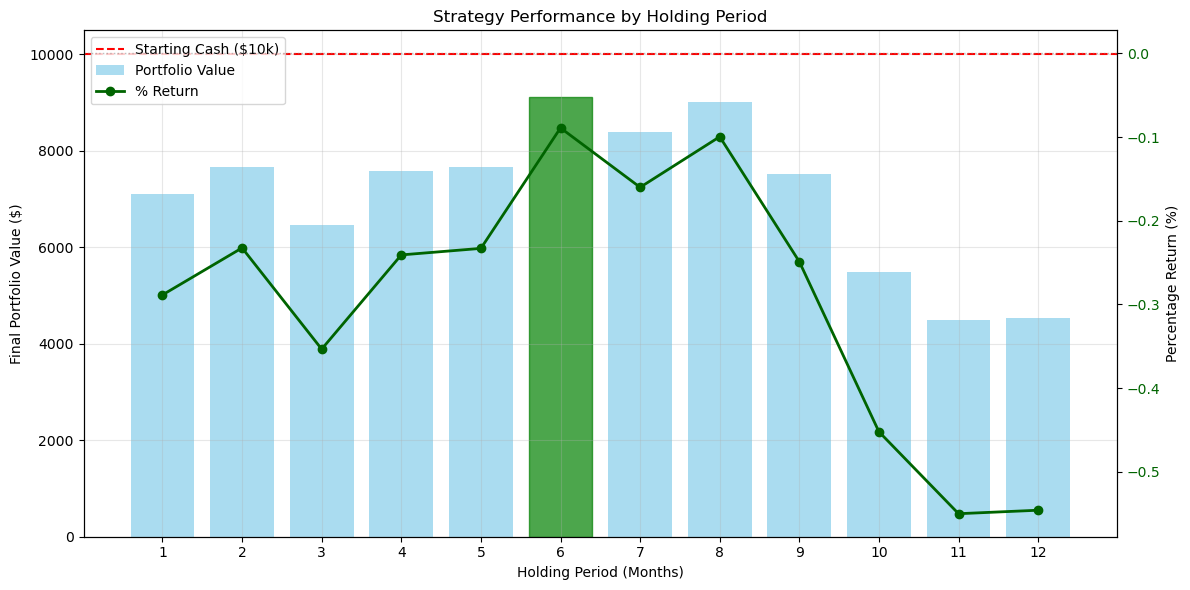

In [41]:
best_soybeans_months, best_soybeans_pnl, soybeans_cash_results, soybeans_return_results = optimize_holding_period(
    soybeans_prices, soybeans_buy_signals, 'soybeans', 1, 12,
)
plot_optimization_results(soybeans_cash_results, soybeans_return_results, best_soybeans_months)

Now, with rollover costs, we can see that soybeans are no longer profitable.

Final Portfolio Value: $9109.32
Annualized Return: -0.85%


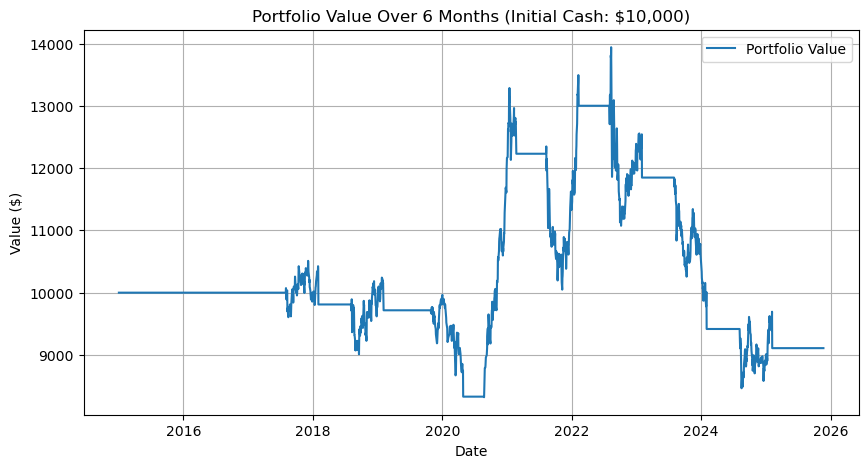

In [42]:
plot_returns(soybeans_prices, soybeans_buy_signals, 6, 'soybeans')

## Summary:
After a more accurate backtest, coffee no longer exhibits a random walk, and is viable for our strategy

- **Coffee:** 5.79% / Year (exhibits random walk)
- **Corn:** 2.30% / Year
- **Lean Hogs:** 10.38% / Year (also the least volatile)
- **Soybeans:** -0.85% / Year (no longer profitable)